# Aperture
The purpose of this notebook is to show all sub-functions necessary to compute the aperture distribution in a single dish radio telescope (or emitting antenna). The aperture distribution, $\underline{E_\text{a}}(x, y)$ is a 2-dim function which depends on,

$$    \underline{E_\text{a}}(x, y) = B(x, y) \cdot E_\text{a}(x, y) \cdot \mathrm e^{\mathrm{i}\varphi(x, y)} $$

Where is $E_\text{a}(x, y)$ is the illumination function, or taper. The $B(x, y)$ is the telescope's geometry or blockage and $\varphi(x, y)$ the phase error and it can be expressed as wavefront (aberration) distribution, $\varphi(x, y) = 2\pi W(x, y)$.


In [82]:
# Adjustin notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [83]:
# importing math and plot packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.constants import golden  # Golden ratio
from astropy.io import ascii  # to read examples
from pyoof import telgeometry, aperture, cart2pol, wavevector2degrees

# Plotting parameters, to make it nicer :) 
matplotlib.rcParams['figure.figsize'] = (golden * 7, 7)
matplotlib.rcParams['figure.subplot.wspace'] = 0.5
matplotlib.rcParams['figure.subplot.left'] = 0.1
matplotlib.rcParams['figure.subplot.bottom'] = 0.2
matplotlib.rcParams['figure.subplot.right'] = 1
matplotlib.rcParams['figure.subplot.top'] = 0.85
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['axes.titlesize'] = 15

### Blockage
The blockage or the telecope geometry, $B(x, y)$, is specific for every telescope. In general the structure it is given by a main dish and a sub-reflector dish. From the OOF holography study, it has been found that the structure plays an important role in the least squares beam fit procedure and it is suggested to make it as accurate as possible.
Below is the case for a generic telescope configuration and Effelsberg.

In [147]:
pr = 50  # Efffelsber primary reflector radius in meters
box_size = pr * 5
resolution = 2 ** 12
x = np.linspace(-box_size, box_size, resolution)
y = x  # squared mesh
x_grid, y_grid = np.meshgrid(x, y)

# Let's look up at some of the basic parameters of a manual configuration
help(telgeometry.blockage_manual)

Help on function blockage_manual in module pyoof.telgeometry.telgeometry:

blockage_manual(pr, sr, a, L)
    Truncation for the aperture function, manual set up for the primary radius
    (pr), secondary radius (sr), hald thickness of a support leg (a) and
    length of the support leg (L) measured from the edge of the sr. It has been
    considered 4 support legs. To omit sr, a and L set them to zero.
    
    Parameters
    ----------
    pr : float
        Primary reflector radius.
    sr : float
        Seconday reflector radius.
    a : float
        Half thickness of a support leg.
    L : float
        Length of a support leg, measured from the edge of the sr to its end.
    
    Returns
    -------
    block : func
        It returns the function block(x, y), which depends only on the grid
        values.



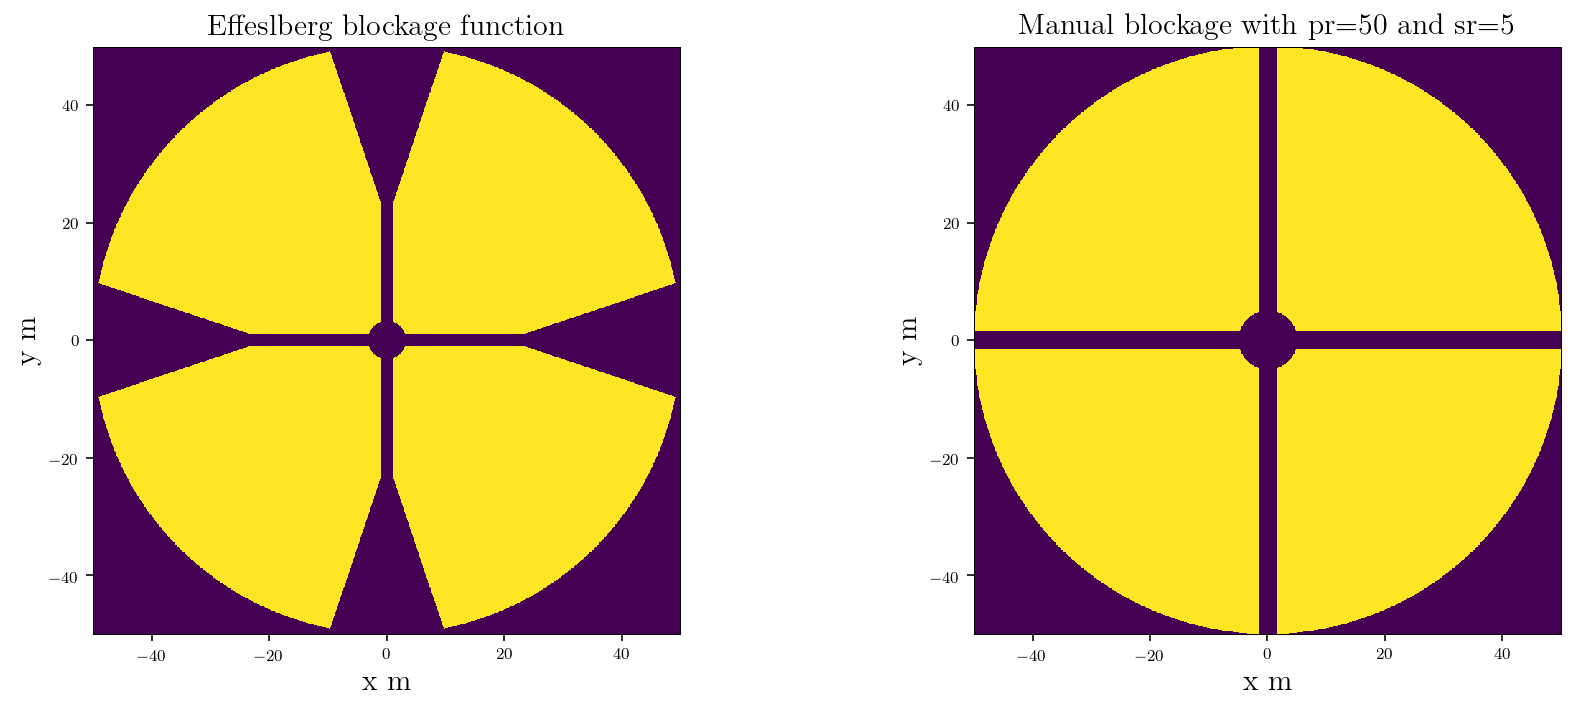

In [156]:
# Testing the blockage functions
sr = 5  # sub-reflector radius in meters
a = 1.5  # halfthicknes of the support legs
L = pr - sr  # length legs, pr - sr from edge to sr 

_blockage_manual = telgeometry.blockage_manual(pr=pr, sr=5, a=1.5, L=50)(x=x_grid, y=y_grid)
_blockage_effelsberg = telgeometry.blockage_effelsberg(x=x_grid, y=y_grid)

fig, ax = plt.subplots(ncols=2)

extent = [-box_size, box_size, -box_size, box_size]
    
ax[0].set_title('Effeslberg blockage function')
ax[0].imshow(_blockage_effelsberg, extent=extent, origin='lower')

ax[1].set_title('Manual blockage with pr=' + str(pr) + ' and sr=' + str(sr))
ax[1].imshow(_blockage_manual, extent=extent, origin='lower')

for _ax in ax:
    _ax.set_xlabel('x m')
    _ax.set_ylabel('y m')
    _ax.grid('off')
    _ax.set_xlim(-pr, pr)
    _ax.set_ylim(-pr, pr)

### Illumination
The illumination function it is also a 2-dim grid, it is usually presented as a 1-dim function in books to compare between several types. There are several important parameters in an illumination functions, its offset $(x_0, y_0)$, amplitud, taper in dB and the order (may or may not have). 

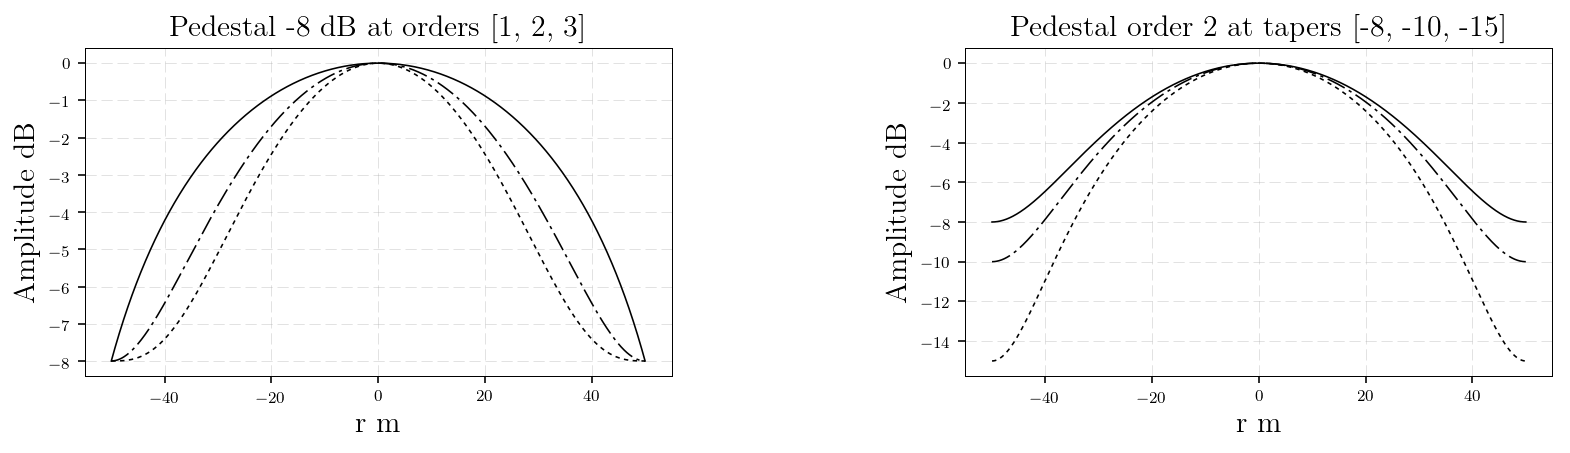

In [106]:
plt.close(fig)  # to not have mixed plots
# importing the illumination functions
fig, ax = plt.subplots(ncols=2, figsize=(golden * 7, 7/2))

orders = [1, 2, 3]
tapers = [-8, -10, -15]

x_linear = np.linspace(-pr, pr, 1e3)

for order, taper, linestyle in zip(orders, tapers, ['-', '-.', ':']):
    _illum_order = aperture.illumination_pedestal(
        x=x_linear, 
        y=0, 
        I_coeff=[1, -8, 0, 0],
        pr=pr,
        order=order
        )
    
    __illum_taper = aperture.illumination_pedestal(
        x=x_linear,
        y=0,
        I_coeff=[1, taper, 0, 0],
        pr=pr,
        order=2
        )
    
    ax[0].plot(x_linear, 20 * np.log10(_illum_order), linestyle=linestyle, c='k')
    ax[0].set_title('Pedestal -8 dB at orders ' + str(orders))

    ax[1].set_title('Pedestal order 2 at tapers ' + str(tapers))
    ax[1].plot(x_linear, 20 * np.log10(__illum_taper), linestyle=linestyle, c='k')

for _ax in ax:
    _ax.set_xlabel('r m')
    _ax.set_ylabel('Amplitude dB')


The application of the illumination to the blockage structure is straight forward, just a simple multiplication.

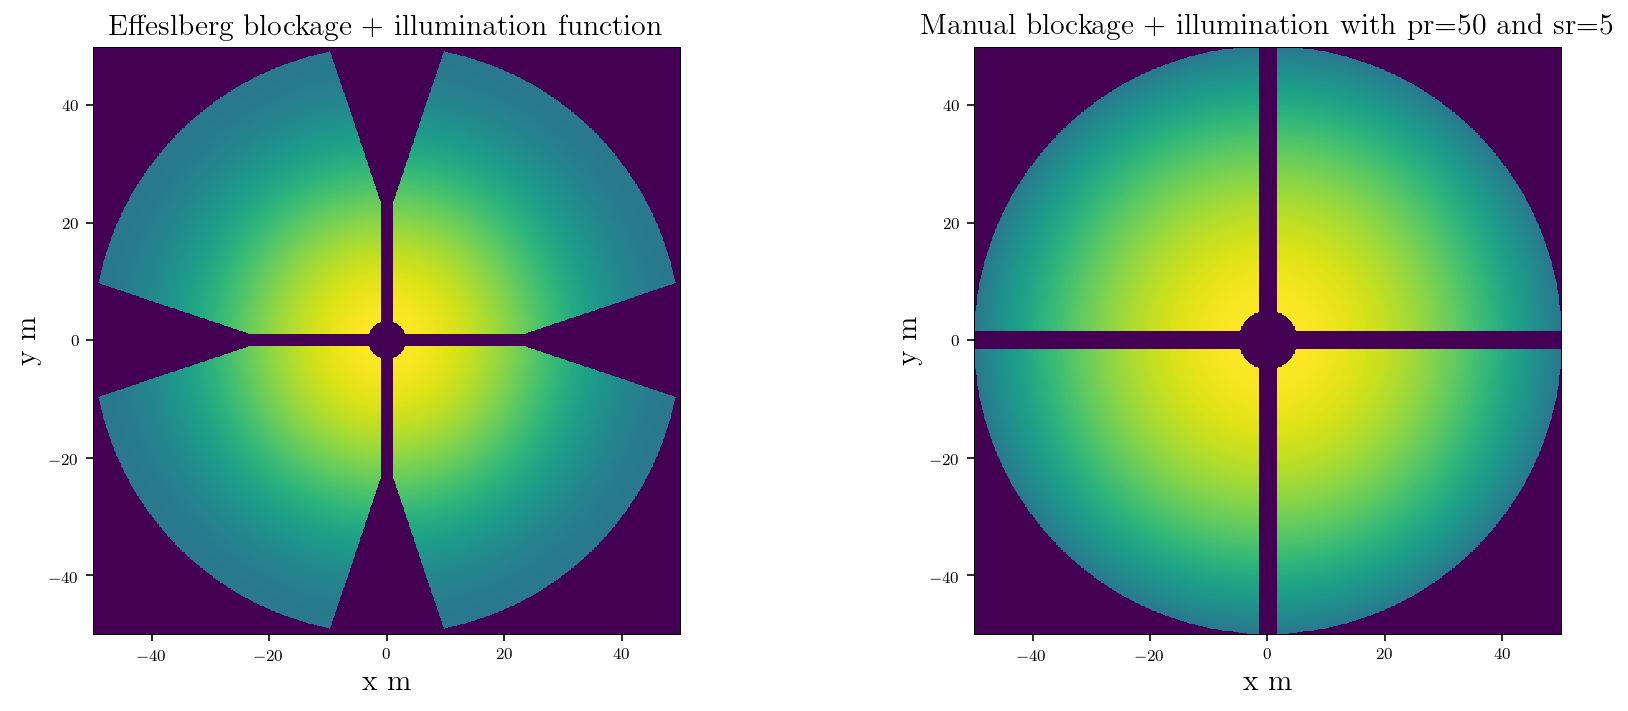

In [155]:
# Defining the illumination function for the Effelsberg telecope
_illum_effeslberg = aperture.illumination_pedestal(
    x=x_grid, y=y_grid, I_coeff=[1, -8, 0, 0], pr=pr, order=2
    )
_illum_manual = aperture.illumination_pedestal(
    x=x_grid, y=y_grid, I_coeff=[1, -8, 0, 0], pr=pr, order=1
    )
_aperture_nophase_effelsber = _blockage_effelsberg * _illum_effeslberg
_aperture_nophase_manual = _blockage_manual * _illum_manual

plt.close(fig)  # to not have mixed plots
fig, ax = plt.subplots(ncols=2)

ax[0].set_title('Effeslberg blockage + illumination function')
ax[0].imshow(_aperture_nophase_effelsber, extent=extent)

ax[1].set_title('Manual blockage + illumination with pr=' + str(pr) + ' and sr=' + str(sr))
ax[1].imshow(_aperture_nophase_manual, extent=extent)

for _ax in ax:
    _ax.grid('off')
    _ax.set_xlabel('x m')
    _ax.set_ylabel('y m')
    _ax.set_xlim(-pr, pr)
    _ax.set_ylim(-pr, pr)
    
plt.show()

### Phase error
To understand where does the phase error function come from, first take a look at the `zernike.ipynb` notebook, it explains the formulation of the Zernike cirlce polynomials and their coefficients. 
In general terms, the $\varphi(x, y)$ function is the wavefront (aberration) distribution, $W(x, y)$, in radians, can be a complex quantity and it belongs to the deformation (and other effects) of the primary dish. The wavefront-phase relation is $\varphi(x, y) = 2\pi W(x, y)$.
To compute it we start with a given set of Zernike circle polynomials.

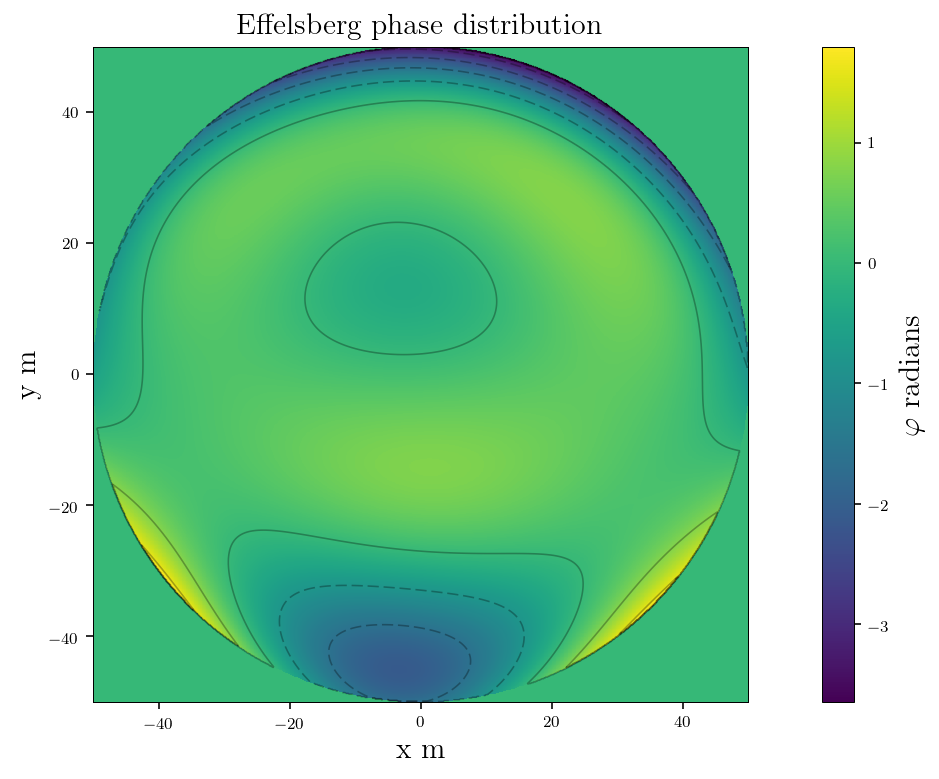

In [160]:
# Coefficients from example
K_coeff = ascii.read('examples/fitpar_n5.dat')['parfit'][4:]

# no tilt
K_coeff_notilt = K_coeff.copy()
K_coeff_notilt[1] = 0
K_coeff_notilt[2] = 0

r, t = cart2pol(x_grid, y_grid)
r_norm = r / pr  # radii normalisation, Zernike circle polynomials

# Phase error
_W = aperture.W(rho=r_norm, theta=t, K_coeff=K_coeff_notilt)
_W[x_grid ** 2 + y_grid ** 2 > pr ** 2] = 0
_phase = _W * 2 * np.pi

plt.close(fig)  # to not have mixed plots
fig, ax = plt.subplots()

im = ax.imshow(_phase, extent=extent)
ax.contour(x, y, _phase, level=5, colors='k', alpha=0.3)
ax.set_title('Effelsberg phase distribution')

cb = fig.colorbar(im, ax=ax, shrink=1)
cb.formatter.set_powerlimits((0, 0))
cb.ax.yaxis.set_offset_position('left')
cb.update_ticks()
cb.ax.set_ylabel('$\\varphi$ radians')

ax.grid('off')
ax.set_xlabel('x m')
ax.set_ylabel('y m')
ax.set_xlim(-pr, pr)
ax.set_ylim(-pr, pr)

plt.show()

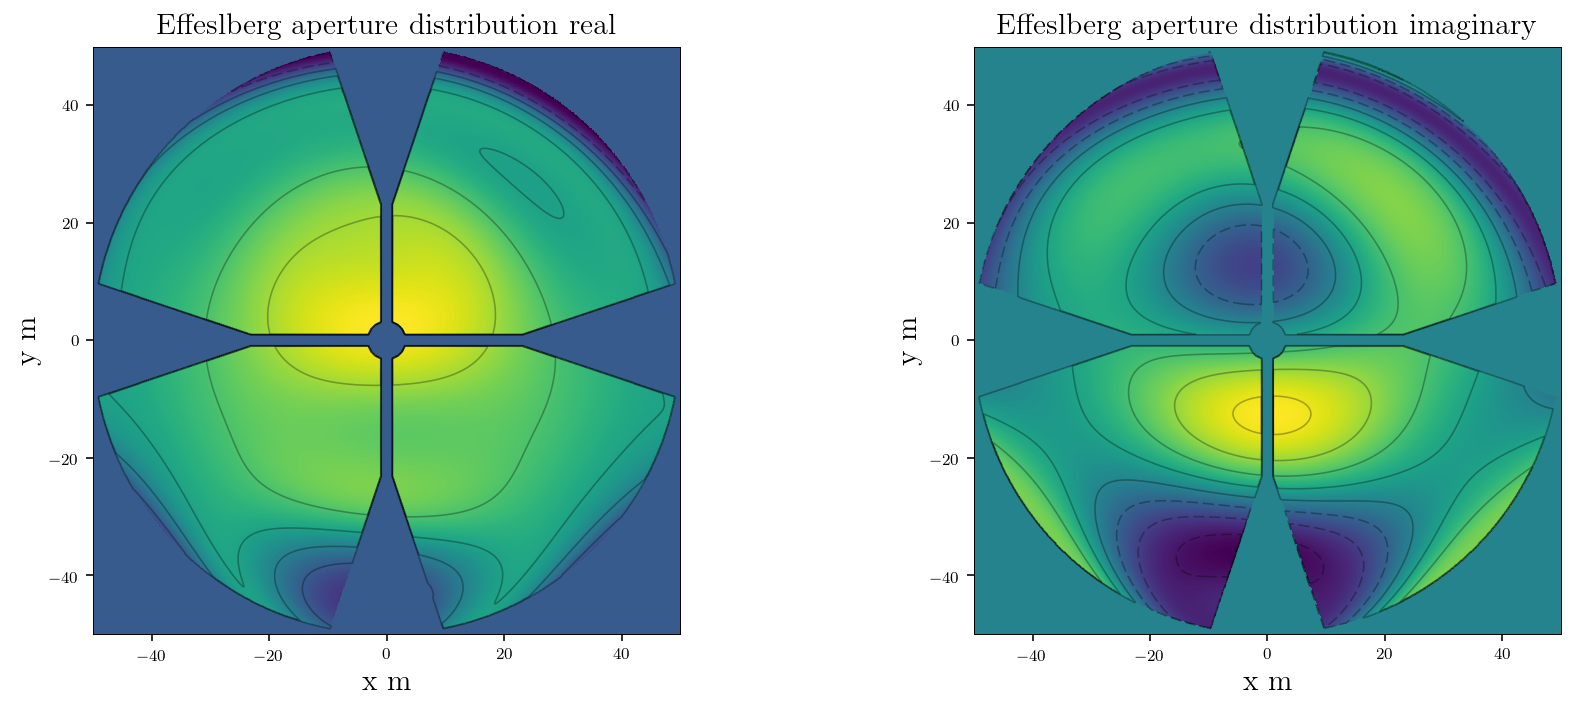

In [151]:
# then the final aperture
aperture_effelsberg = (np.exp(1j * _phase) * _aperture_nophase_effelsber)

plt.close(fig)  # to not have mixed plots
fig, ax = plt.subplots(ncols=2)

ax[0].imshow(aperture_effelsberg.real, extent=extent)
ax[0].contour(x_grid, y_grid, aperture_effelsberg.real, level=5, colors='k', alpha=0.3)
ax[0].set_title('Effeslberg aperture distribution real')

ax[1].imshow(aperture_effelsberg.imag, extent=extent)
ax[1].contour(x_grid, y_grid, aperture_effelsberg.imag, level=5, colors='k', alpha=0.3)
ax[1].set_title('Effeslberg aperture distribution imaginary')

for _ax in ax:
    _ax.grid('off')
    _ax.set_xlabel('x m')
    _ax.set_ylabel('y m')
    _ax.set_xlim(-pr, pr)
    _ax.set_ylim(-pr, pr)

plt.show()

The above result is aperture distribution model in the telescope's primary dish. Once the model of the aperture distribution is computed it is possible to apply the Fourier Transform to it and find the telescope's power pattern.

### Optical path difference 
What it is observed by a radio telescope is its power pattern (or in the optical wavelenght the intensity). For OOF holography purposes it is necessary to reconstruct from the power pattern, $P(u, v)$,  the aperture distribution, $\underline{E_\text{a}}(x, y)$, which is exactly a squared norm of a Fourier Transform,

$$   P(u, v) =  \left| \mathcal F\left[\underline{E_\text{a}}(x, y)\right] \right|^2  = \left | \iint\limits_{S_\text{a}} \underline{E_\text{a}}(x',y') \cdot \mathrm{e}^{-\mathrm{i}2\pi(x'u+y'v)}\,\mathrm{d} S' \right|^{\, 2}. $$

To solve the under-determined problem (information lost due to complex number) a radial offset is added to the radio telescope, which originates a change in the phase error function, 

$$\varphi'(x, y) = \varphi(x, y) + \frac{2\pi}{\lambda}\delta(x, y;d_z)$$

where the function $\delta(x, y;d_z)$ is known returns the optical path difference in the system. The path difference function, $\delta(x, y;d_z)$, depends on the telescope geometry and its configuration. The software needs three measurements and the input value for the path difference function is the radial offset distance, $d_z$. 

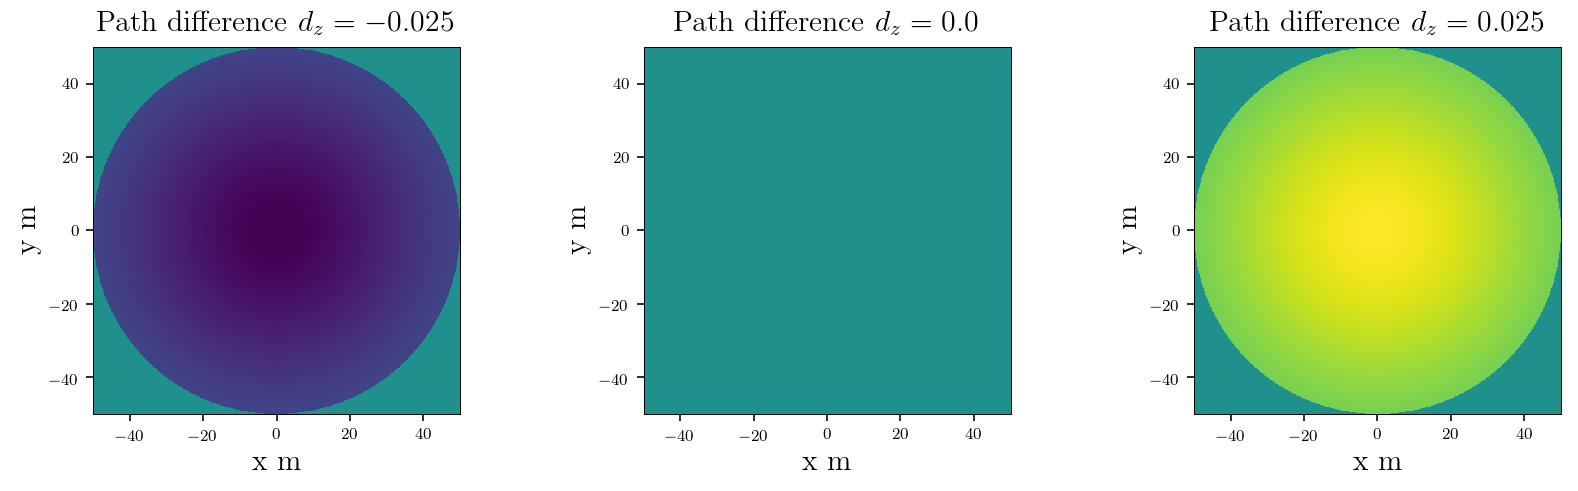

In [154]:
# Following the same example as before, three observations
# with a radial offset of -0.025, 0, 0.025 m in the sub-reflector.
d_z = np.array([-0.025, 0, 0.025])  # m

plt.close(fig)  # to not have mixed plots
fig, ax = plt.subplots(ncols=3)
for i in range(3):
    _delta = aperture.delta(x=x_grid, y=y_grid, d_z=d_z[i])
    _delta[x_grid ** 2 + y_grid ** 2 > pr ** 2] = 0
    ax[i].imshow(_delta, extent=extent, vmin=d_z[0]*2, vmax=d_z[2]*2)
    ax[i].grid('off')
    ax[i].set_xlabel('x m')
    ax[i].set_ylabel('y m')
    ax[i].set_title('Path difference $d_z = ' + str(d_z[i]) + '$')
    ax[i].set_xlim(-pr, pr)
    ax[i].set_ylim(-pr, pr)

plt.show()


for the zero case, $\delta(x, y;d_z=0)=0$ there will be no change in the optics. Adding the new phase error, $\varphi'$, to the aperture distribution, will generate a slight change in the final function, but it is necessary to compute the power pattern, $P(u, v)$. On the other hand, in the power pattern there will be a significant change due to the defocused parameter.

### Power pattern
To compute the power pattern, we simply use the Fourier transform, but now for every offset added, this is,

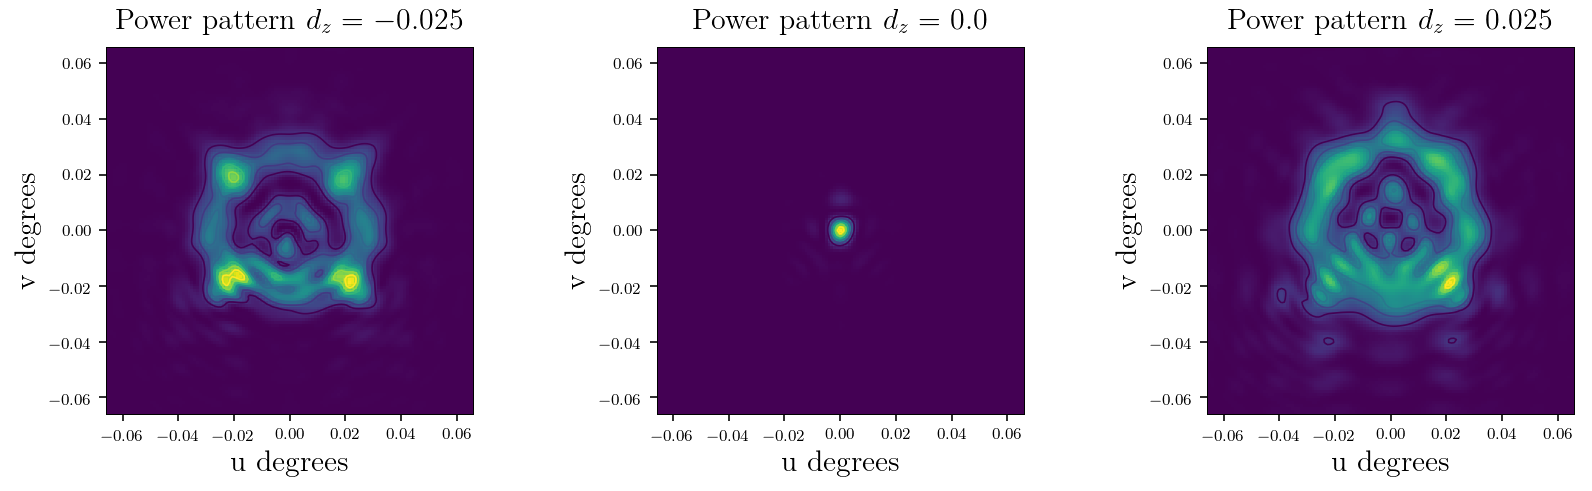

In [153]:
# To transform the path difference to radians
# Observation wavelength
wavel = 0.009  # m

fig, ax = plt.subplots(ncols=3)

for i in range(3):
    _delta = aperture.delta(x=x_grid, y=y_grid, d_z=d_z[i])
    _phase_new = _delta * 2 * np.pi / wavel + _phase
    aperture_effelsberg = (np.exp(1j * _phase_new) * _aperture_nophase_effelsber)

    F = np.fft.fft2(aperture_effelsberg)
    F_shift = np.fft.fftshift(F)
    power_pattern = np.abs(F_shift) ** 2

    # data resolution
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    u, v = np.fft.fftfreq(x.size, dx), np.fft.fftfreq(y.size, dy)
    u_shift, v_shift = np.fft.fftshift(u), np.fft.fftshift(v)
    u_deg, v_deg = wavevector2degrees(u_shift, wavel), wavevector2degrees(v_shift, wavel)
    
    extent_uv = [u_deg.min(), u_deg.max(), v_deg.min(), v_deg.max()]

    b_factor = 1.22 * wavel / (2 * pr)  # Beamwidth
    plim_u = [-600 * b_factor, 600 * b_factor]
    plim_v = [-600 * b_factor, 600 * b_factor]
    
    ax[i].imshow(power_pattern, extent=extent_uv)
    ax[i].contour(u_deg, v_deg, power_pattern, level=5)
    ax[i].set_xlim(*plim_u)
    ax[i].set_ylim(*plim_v)
    
    ax[i].grid('off')
    ax[i].set_xlabel('u degrees')
    ax[i].set_ylabel('v degrees')
    ax[i].set_title('Power pattern $d_z = ' + str(d_z[i]) + '$')

plt.show()
